## The Advanced Computing Center for Research and Education

The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

When a job is submitted to ACCRE, it goes through the slurm scheduler, which tracks and manages compute and memory resources. It is hypothesized that the slurm scheduler is processing so many job completions so frequently that it sometimes becomes unresponsive to commands from users trying to schedule new jobs or check job status. This is a particularly bad problem for clients who use automated submission systems, such as members of the Open Science Grid. The goal of this project is to investigate and potentially confirm that hypothesis that lots of job completions in a short time period are causing the scheduler to be unresponsive, and determine the rough threshold at which it becomes an issue.

You have been provided three datasets for this task:
* **fullsample.csv**: This file contains output for jobs run through the slurm scheduler.
* **slurm_wrapper_ce5.log** and **slurm_wrapper_ce6.log**: Logs of every slurm command that a pair of servers, ce5 and ce6, executed, how long it took, and if it succeeded. These servers connect ACCRE's local cluster to the Open Science Grid and submit jobs to slurm on behalf of the grid.

To get started, answer the following questions using just the fullsample.csv jobs dataset:

1. Calculate some descriptive statistics for how many jobs per hour are being completed. What does the completions per hour look like over the time span of the dataset? Are there weekly trends, and has it been increasing over the last year?

2. Does the job state affect completions per hour? i.e. if I only look at jobs with exit code 0:0 in the "COMPLETED" state, is that a similar number of completions per hour as with all jobs, failed or cancelled? This will indicate if the load on the scheduler is by user design or is a result of users not sufficiently testing their jobs before submitting very large arrays. We also expect that most job completions will be in the "production" partition, but is this actually true?

Next, use the two log files to determine time intervals (hours) when the scheduler was unresponsive. Do this by looking for records that are the "sbatch" command from user 9204 that have return code 1 and an execution time of ~20 seconds (at least more than 15). These are commands where the scheduler timed out in responding.

3. Calculate some descriptive statistics about how often the scheduler was unresponsive, how long these periods of time were, and create a time series plot of when the scheduler was having difficulties.

4. Finally, combine the time series information from the two datasets together to see how well correlated heavy job-completion load is with the unresponsiveness, and to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
scheduler = pd.read_csv('../data/accre-scheduler-data-2021/fullsample.csv')

In [43]:
# replace Unknown string with NaN in BEGIN and END columns, convert strings to datetime dtype in BEGIN and END columns
scheduler['END'] = scheduler['END'].replace('Unknown', np.nan)
scheduler['END']=pd.to_datetime(scheduler['END'])
scheduler['BEGIN'] = scheduler['BEGIN'].replace('Unknown', np.nan)
scheduler['BEGIN']=pd.to_datetime(scheduler['BEGIN'])

In [8]:
# create dataframes of COMPLETED, CANCELLED, and FAILED state
completed = scheduler[scheduler['STATE']=='COMPLETED'].sort_values('END')
cancelled = scheduler[scheduler['STATE']=='CANCELLED'].sort_values('END')
failed = scheduler[scheduler['STATE']=='FAILED'].sort_values('END')

In [10]:
# extract date from END column and save it to ENDDATE column 
completed['ENDDATE']=completed['END'].dt.date

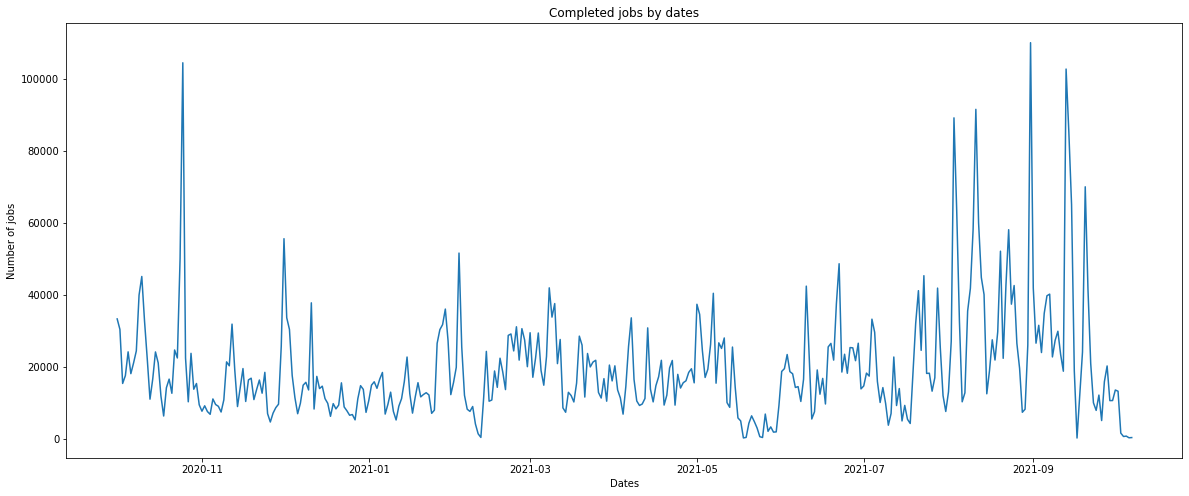

In [12]:
# complted jobs by dates
plt.figure(figsize = (20,8))
completed.groupby(completed['ENDDATE']).count()['JOBID'].plot()
plt.title('Completed jobs by dates')
plt.xlabel('Dates')
plt.ylabel('Number of jobs');


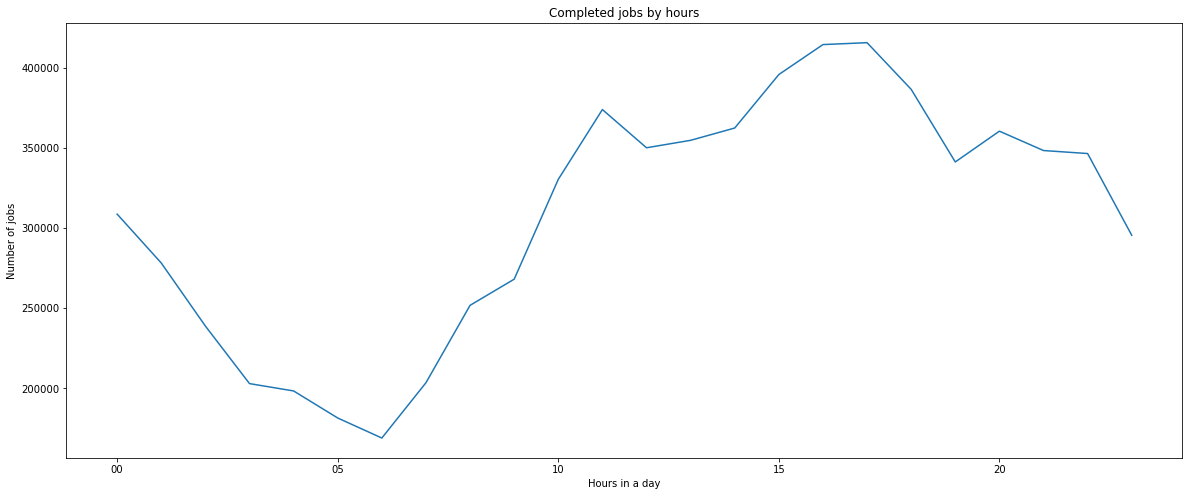

In [96]:
# completed jobs by hours
completed_by_hour = completed.groupby(completed['END'].dt.strftime('%H')).count()
plt.figure(figsize = (20,8))
completed_by_hour['JOBID'].plot()
plt.title('Completed jobs by hours')
plt.xlabel('Hours in a day')
plt.ylabel('Number of jobs');

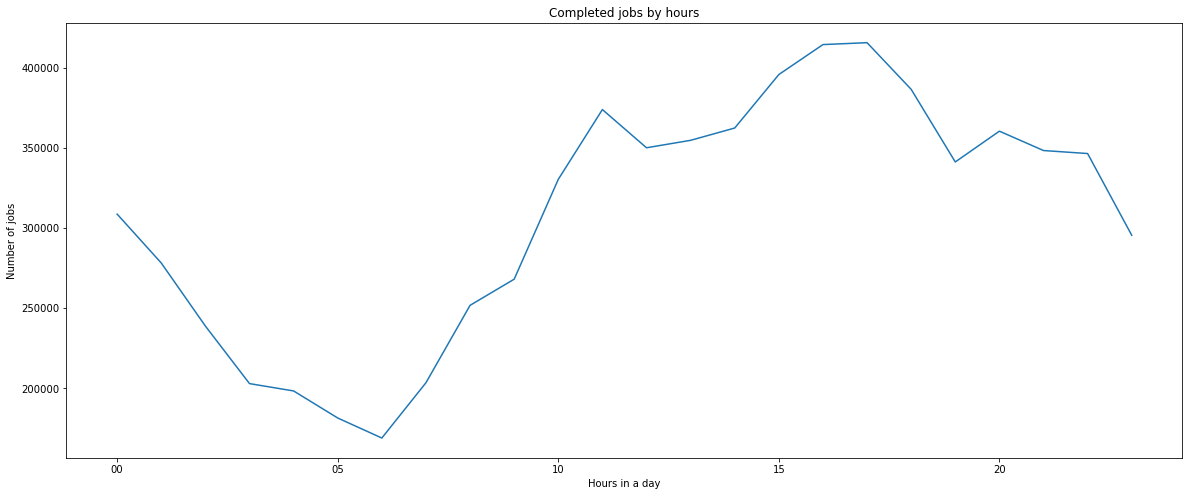

In [13]:
# completed jobs by days
completed_by_day = completed.groupby(completed['END'].dt.strftime('%d')).count()

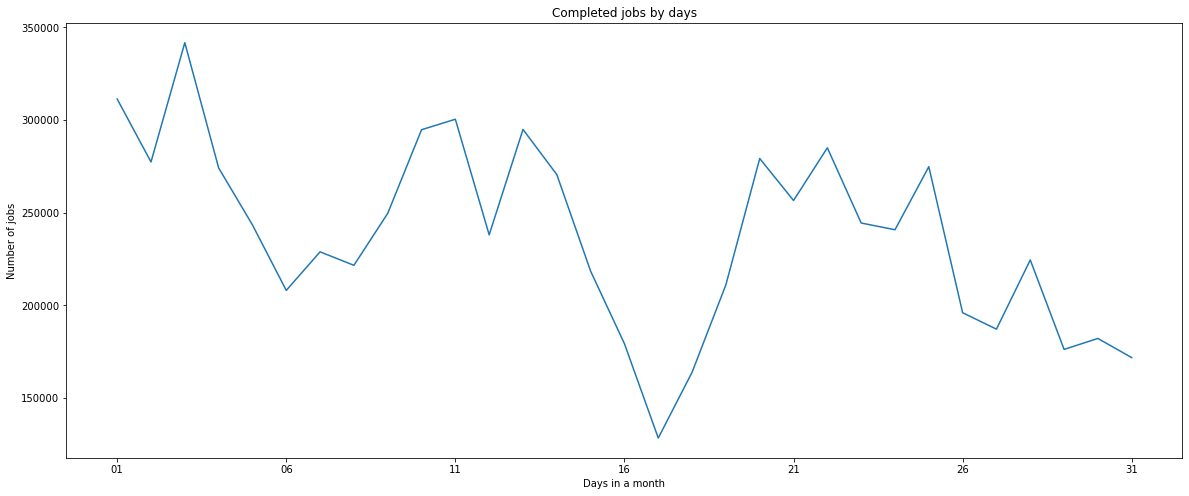

In [14]:
plt.figure(figsize = (20,8))
completed_by_day['JOBID'].plot()
plt.title('Completed jobs by days')
plt.xlabel('Days in a month')
plt.ylabel('Number of jobs');

In [15]:
# completed jobs by weeks
completed_by_week = completed.groupby(completed['END'].dt.strftime('%W')).count()

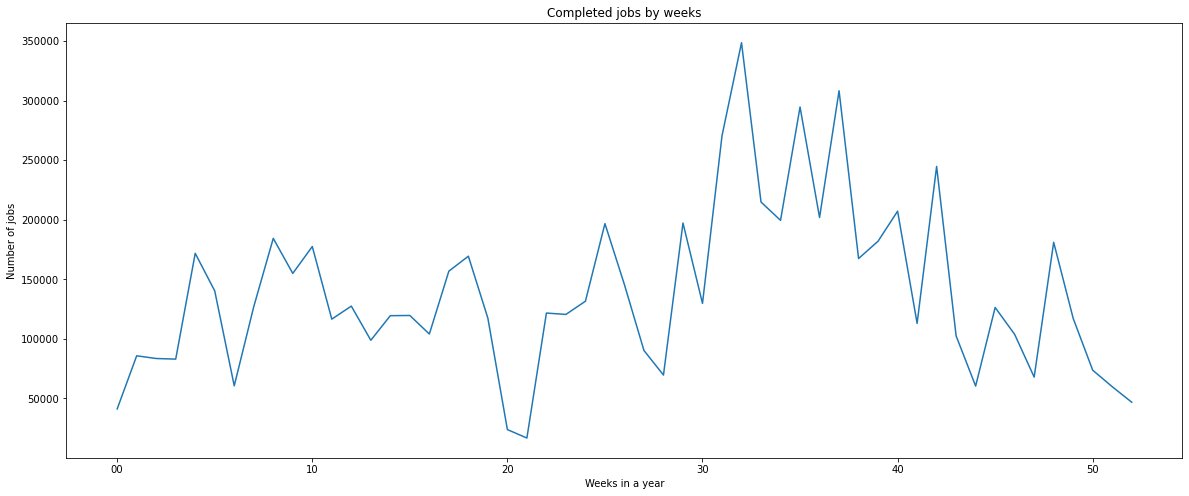

In [16]:
plt.figure(figsize = (20,8))
completed_by_week['JOBID'].plot()
plt.title('Completed jobs by weeks')
plt.xlabel('Weeks in a year')
plt.ylabel('Number of jobs');

In [82]:
# completed jobs by weekday, 0 is Sunday and 1 is Monday, so on so forth
completed_by_weekday = completed.groupby(completed['END'].dt.strftime('%w')).count()

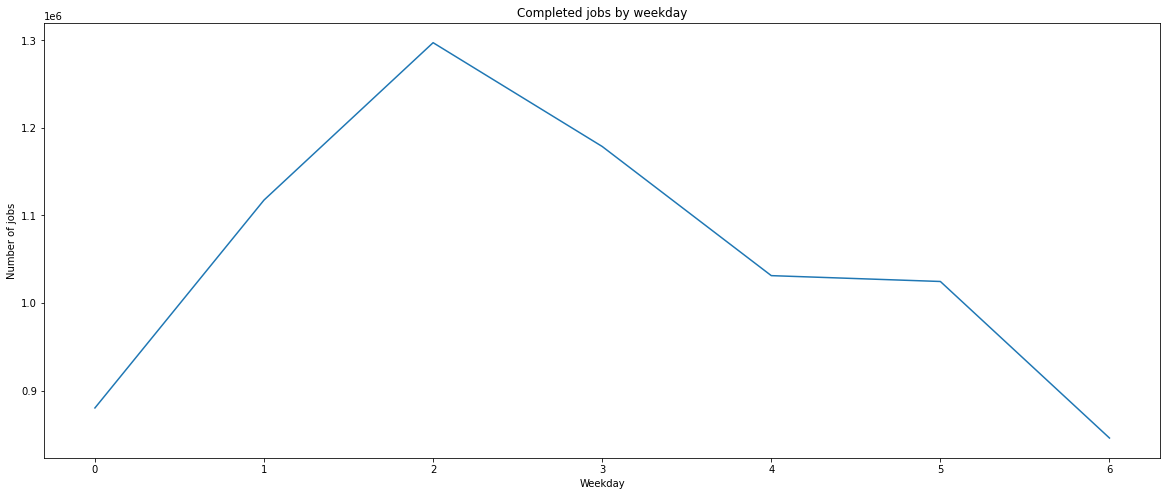

In [90]:
plt.figure(figsize = (20,8))
completed_by_weekday['JOBID'].plot()
plt.title('Completed jobs by weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of jobs');

In [88]:
completed_by_month = completed.groupby(completed['END'].dt.strftime('%m')).count()

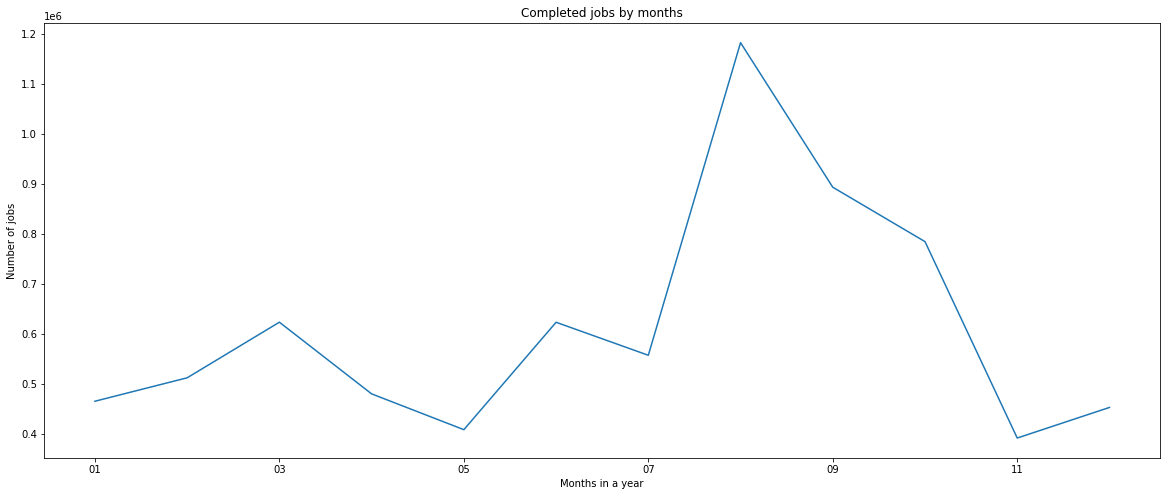

In [89]:
plt.figure(figsize = (20,8))
completed_by_month['JOBID'].plot()
plt.title('Completed jobs by months')
plt.xlabel('Months in a year')
plt.ylabel('Number of jobs');

In [21]:
# define a function to calculate completions per hour
def completions_per_hour(column):
    timedelta = column.iloc[-1]-column.iloc[0]
    result = len(column)/(timedelta.days*24+timedelta.seconds/3600)
    return result

In [22]:
# calculate completions per hour
completed_per_hour = completions_per_hour(completed['END'])
cancelled_per_hour = completions_per_hour(cancelled['END'])
failed_per_hour = completions_per_hour(failed['END'])

In [23]:
print(f'The complettions per hour of the COMPLETED State is {completed_per_hour}')
print(f'The complettions per hour of the CANCELLED State is {cancelled_per_hour}')
print(f'The complettions per hour of the FAILED State is {failed_per_hour}')

The complettions per hour of the COMPLETED State is 826.3847997227114
The complettions per hour of the CANCELLED State is 1.022292454607979
The complettions per hour of the FAILED State is 0.4293458537039535


In [26]:
# percent of PARTITION in completed state
completed['PARTITION'].value_counts(normalize = True)

production              9.494376e-01
nogpfs                  1.988574e-02
pascal                  1.667276e-02
sam                     8.808713e-03
turing                  2.798341e-03
maxwell                 1.488797e-03
cgw-maizie              5.782985e-04
debug                   1.944385e-04
cgw-platypus            5.030451e-05
cgw-dsi-gw              3.077931e-05
cgw-capra1              2.047434e-05
cgw-dougherty1          1.518627e-05
cgw-horus               8.271092e-06
cgw-cqs1                3.525384e-06
cgw-hanuman             2.847425e-06
cgw-sideshowbob         1.762692e-06
cgw-vm-qa-flatearth1    1.220325e-06
cgw-tbi01               9.491417e-07
Name: PARTITION, dtype: float64

In [27]:
# percent of PARTITION in cancelled state
cancelled['PARTITION'].value_counts(normalize = True)

production        0.813142
pascal            0.089895
turing            0.070458
nogpfs            0.009608
maxwell           0.008945
debug             0.004638
cgw-maizie        0.001767
cgw-dougherty1    0.000994
cgw-platypus      0.000442
sam               0.000110
Name: PARTITION, dtype: float64

In [28]:
# percent of PARTITION in failed state
failed['PARTITION'].value_counts(normalize = True)

production    0.734466
pascal        0.159586
maxwell       0.050982
turing        0.028147
debug         0.025491
nogpfs        0.001328
Name: PARTITION, dtype: float64

In [63]:
# calculate the USEDTIME by hour
scheduler['USEDTIME']=(scheduler['END']-scheduler['BEGIN'])/pd.to_timedelta(1,'H')

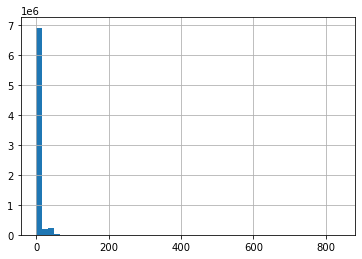

In [73]:
# histgram of USEDTIME
scheduler['USEDTIME'].hist(bins=50);